In [10]:
import numpy as np

def get_condition_indices(stabilizer_shape):
    """
    Extracts the list of relative positions (dx, dy) from a m x n binary rule matrix
    that define which neighbor cells contribute to the update rule.

    The (0, *) row is ignored (assumed to represent the current cell),
    and only rows over 1 are used to define condition offsets.
    """
    rows, cols = stabilizer_shape.shape
    print(f"Stabilizer shape:\n{stabilizer_shape}")
    print(f"Rows: {rows}, Cols: {cols}")
    # set (0, 0) for all row 0
    
    relative_positions = [[(i, j) for j in range(-cols//2 + 1, cols//2 + 1)] for i in range(rows)]
    for j in range(cols):
        relative_positions[0][j] = (0, 0)
        
    active_conditions = []               

    for i in range(1, rows):
        for j in range(cols):
            if stabilizer_shape[i][j] == 1:
                active_conditions.append(relative_positions[i][j])

    return active_conditions

def fill_Z_with_stabilizer_shape(input_row, H, L, m, condition_offsets_list, same_shape=False):
    """Evolve the automaton from the input_row using given rule offsets."""
    print(f"condition offsets list: {condition_offsets_list}")
    
    Z = np.zeros((H - m + 1, L), dtype=int)
    Z = np.append(Z, input_row, axis=0)  # append input row at the bottom
    for i in range(H - m, -1, -1):  # evolve upward
        condition_offsets = condition_offsets_list[H - m - i] if same_shape == False else condition_offsets_list[0]  # get the condition offsets for this row
        for j in range(L):
            neighbor_sum = 0
            for dx, dy in condition_offsets:
                neighbor_sum += Z[i + dx, (j + dy) % L]
            Z[i, j] = 1 if neighbor_sum % 2 == 1 else 0  # parity check

    return Z

# Generate parity-check matrix H
def generate_parity_check_matrix(H, L, m, condition_indices):
    n = H * L # number of physical qubits
    k = L * (m - 1)  # number of logical qubits
    print(f"Generating parity-check matrix for H={H}, L={L}, m={m}, n={n}, k={k}")
    num_checks = n - k # n - k
    H_matrix = np.zeros((num_checks, n), dtype=int)

    print(f"Generating H matrix of size {num_checks} x {n}")

    parity_check_row_idx = 0
    for i in range(H - m, -1, -1):
        for j in range(L):
            cur_parity_check_column_idx = (H - i - 1) * L + j
            H_matrix[parity_check_row_idx, cur_parity_check_column_idx] = 1

            # side cell should be applied periodic boundary condition

            condition_offsets = condition_indices
            for dx, dy in condition_offsets:
                target_row = (H - i - 1) - dx
                target_col = (j + dy) % L
                
                parity_check_column_idx = target_row * L + target_col
                H_matrix[parity_check_row_idx, parity_check_column_idx] = 1
            # print index of 1
            # for col in range(H_matrix.shape[1]):
            #     if H_matrix[check_row][col] == 1:
            #         print(f"({check_row}, {col})", end=' ')
            # print()
            parity_check_row_idx += 1

    return H_matrix


H, L = 8, 17
m = 3
stabilizer_shape = np.array([[0, 1, 0],
                            [0, 1, 0],
                            [1, 0, 1]])

condition_indices = get_condition_indices(stabilizer_shape)
print("Condition indices (dx, dy):", condition_indices)

H_matrix = generate_parity_check_matrix(H, L, m, condition_indices)

print("Generated Parity-Check Matrix H:")
# print H index of 1
for i in range(H_matrix.shape[0]):
    print(f'\n${i} parity-check: ', end='')
    for j in range(H_matrix.shape[1]):
        if H_matrix[i][j] == 1:
            print(f"({i}, {j})", end=' ')
print("\nShape of H matrix:", H_matrix.shape)
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
# print(H_matrix)


Stabilizer shape:
[[0 1 0]
 [0 1 0]
 [1 0 1]]
Rows: 3, Cols: 3
Condition indices (dx, dy): [(1, 0), (2, -1), (2, 1)]
Generating parity-check matrix for H=8, L=17, m=3, n=136, k=34
Generating H matrix of size 102 x 136
Generated Parity-Check Matrix H:

$0 parity-check: (0, 1) (0, 16) (0, 17) (0, 34) 
$1 parity-check: (1, 0) (1, 2) (1, 18) (1, 35) 
$2 parity-check: (2, 1) (2, 3) (2, 19) (2, 36) 
$3 parity-check: (3, 2) (3, 4) (3, 20) (3, 37) 
$4 parity-check: (4, 3) (4, 5) (4, 21) (4, 38) 
$5 parity-check: (5, 4) (5, 6) (5, 22) (5, 39) 
$6 parity-check: (6, 5) (6, 7) (6, 23) (6, 40) 
$7 parity-check: (7, 6) (7, 8) (7, 24) (7, 41) 
$8 parity-check: (8, 7) (8, 9) (8, 25) (8, 42) 
$9 parity-check: (9, 8) (9, 10) (9, 26) (9, 43) 
$10 parity-check: (10, 9) (10, 11) (10, 27) (10, 44) 
$11 parity-check: (11, 10) (11, 12) (11, 28) (11, 45) 
$12 parity-check: (12, 11) (12, 13) (12, 29) (12, 46) 
$13 parity-check: (13, 12) (13, 14) (13, 30) (13, 47) 
$14 parity-check: (14, 13) (14, 15) (14, 31) (1

In [2]:
# input_row = np.random.randint(0, 2, size=(m-1, L))
input_row = np.zeros((m-1, L), dtype=int)
input_row[1][8] = 1
print("Input row:")
print(input_row)

Z = fill_Z_with_stabilizer_shape(input_row, H, L, m, [condition_indices], same_shape=True)
print("Generated Z matrix:")
print(Z)
print("Shape of Z matrix:", Z.shape)

Z = Z.flatten()[::-1]  # flatten and reverse
print("Flattened Z vector:")
print(Z)

# syndrome calculation
syndrome = np.mod(H_matrix @ Z, 2)
print("Syndrome:")
print(syndrome)
print("Shape of syndrome:", syndrome.shape)

Input row:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
condition offsets list: [[(1, 0), (2, -1), (2, 1)]]
Generated Z matrix:
[[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
Shape of Z matrix: (8, 17)
Flattened Z vector:
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
Syndrome:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Shape of

In [3]:
import numpy as np

def get_condition_indices(stabilizer_shape):
    """
    Extracts the list of relative positions (dx, dy) from a m x n binary rule matrix
    that define which neighbor cells contribute to the update rule.

    The (0, *) row is ignored (assumed to represent the current cell),
    and only rows over 1 are used to define condition offsets.
    """
    rows, cols = stabilizer_shape.shape
    print(f"Stabilizer shape:\n{stabilizer_shape}")
    print(f"Rows: {rows}, Cols: {cols}")
    # set (0, 0) for all row 0
    
    relative_positions = [[(i, j) for j in range(-cols//2 + 1, cols//2 + 1)] for i in range(rows)]
    for j in range(cols):
        relative_positions[0][j] = (0, 0)
        
    active_conditions = []               

    for i in range(1, rows):
        for j in range(cols):
            if stabilizer_shape[i][j] == 1:
                active_conditions.append(relative_positions[i][j])

    return active_conditions

def fill_Z_with_stabilizer_shape(input_row, H, L, m, condition_offsets_list, same_shape=False):
    """Evolve the automaton from the input_row using given rule offsets."""
    print(f"condition offsets list: {condition_offsets_list}")
    
    Z = np.zeros((H - m + 1, L), dtype=int)
    Z = np.append(Z, input_row, axis=0)  # append input row at the bottom
    for i in range(H - m, -1, -1):  # evolve upward
        condition_offsets = condition_offsets_list[H - m - i] if same_shape == False else condition_offsets_list[0]  # get the condition offsets for this row
        for j in range(L):
            neighbor_sum = 0
            for dx, dy in condition_offsets:
                neighbor_sum += Z[i + dx, (j + dy) % L]
            Z[i, j] = 1 if neighbor_sum % 2 == 1 else 0  # parity check

    return Z

# Generate parity-check matrix H
def generate_parity_check_matrix(H, L, m, condition_indices):
    n = H * L
    num_checks = L * (H - m + 1)
    H_matrix = np.zeros((num_checks, n), dtype=int)

    print(f"Generating H matrix of size {num_checks} x {n}")

    check_row = 0
    for i in range(H - m, -1, -1):
        for j in range(L):
            cur_column_idx = (H - i - 1) * L + j
            H_matrix[check_row, (H - i - 1) * L + j] = 1

            # side cell should be applied periodic boundary condition

            condition_offsets = condition_indices
            for dx, dy in condition_offsets:
                target_row = (H - i - 1) - dx
                target_col = (j + dy) % L
                if 0 <= target_row < H:
                    column_idx = target_row * L + target_col
                    H_matrix[check_row, column_idx] = 1

                H_matrix[check_row, column_idx] = 1
            # print index of 1
            for col in range(H_matrix.shape[1]):
                if H_matrix[check_row][col] == 1:
                    print(f"({check_row}, {col})", end=' ')
            print()
            check_row += 1

    return H_matrix


H, L = 8, 17
m = 3
stabilizer_shape = np.array([[0, 1, 0],
                            [0, 1, 0],
                            [1, 0, 1]])

condition_indices = get_condition_indices(stabilizer_shape)
print("Condition indices (dx, dy):", condition_indices)

H_matrix = generate_parity_check_matrix(H, L, m, condition_indices)

print("Generated Parity-Check Matrix H:")
# print H index of 1
for i in range(H_matrix.shape[0]):
    print(f'\n${i} parity-check: ', end='')
    for j in range(H_matrix.shape[1]):
        if H_matrix[i][j] == 1:
            print(f"({i}, {j})", end=' ')
print("\nShape of H matrix:", H_matrix.shape)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
print(H_matrix)


Stabilizer shape:
[[0 1 0]
 [0 1 0]
 [1 0 1]]
Rows: 3, Cols: 3
Condition indices (dx, dy): [(1, 0), (2, -1), (2, 1)]
Generating H matrix of size 102 x 136
(0, 1) (0, 16) (0, 17) (0, 34) 
(1, 0) (1, 2) (1, 18) (1, 35) 
(2, 1) (2, 3) (2, 19) (2, 36) 
(3, 2) (3, 4) (3, 20) (3, 37) 
(4, 3) (4, 5) (4, 21) (4, 38) 
(5, 4) (5, 6) (5, 22) (5, 39) 
(6, 5) (6, 7) (6, 23) (6, 40) 
(7, 6) (7, 8) (7, 24) (7, 41) 
(8, 7) (8, 9) (8, 25) (8, 42) 
(9, 8) (9, 10) (9, 26) (9, 43) 
(10, 9) (10, 11) (10, 27) (10, 44) 
(11, 10) (11, 12) (11, 28) (11, 45) 
(12, 11) (12, 13) (12, 29) (12, 46) 
(13, 12) (13, 14) (13, 30) (13, 47) 
(14, 13) (14, 15) (14, 31) (14, 48) 
(15, 14) (15, 16) (15, 32) (15, 49) 
(16, 0) (16, 15) (16, 33) (16, 50) 
(17, 18) (17, 33) (17, 34) (17, 51) 
(18, 17) (18, 19) (18, 35) (18, 52) 
(19, 18) (19, 20) (19, 36) (19, 53) 
(20, 19) (20, 21) (20, 37) (20, 54) 
(21, 20) (21, 22) (21, 38) (21, 55) 
(22, 21) (22, 23) (22, 39) (22, 56) 
(23, 22) (23, 24) (23, 40) (23, 57) 
(24, 23) (24, 25)

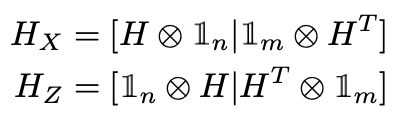

In [4]:
def generate_HGP_matrices(H_matrix):
    m, n = H_matrix.shape
    print(f"Shape of classical H: {m} x {n}")

    I_n = np.identity(n, dtype=int)
    I_m = np.identity(m, dtype=int)

    H_X_left = np.kron(H_matrix, I_n)
    H_X_right = np.kron(I_m, H_matrix.T)
    H_X = np.hstack([H_X_left, H_X_right])

    H_Z_left = np.kron(I_n, H_matrix)
    H_Z_right = np.kron(H_matrix.T, I_m)
    H_Z = np.hstack([H_Z_left, H_Z_right])

    return H_X, H_Z


In [9]:
H_X, H_Z = generate_HGP_matrices(H_matrix)
m, n = H_matrix.shape

print("H_X and H_Z shape are mn x (n^2 + m^2):")
print(f"H_X shape: (mn) x (n^2 + m^2) = ({m}x{n}) x ({n}^2 + {m}^2) = ", H_X.shape)
print(f"H_Z shape: (mn) x (n^2 + m^2) = ({m}x{n}) x ({n}^2 + {m}^2) = ", H_Z.shape)

Shape of classical H: 102 x 136
H_X and H_Z shape are mn x (n^2 + m^2):
H_X shape: (mn) x (n^2 + m^2) = (102x136) x (136^2 + 102^2) =  (13872, 28900)
H_Z shape: (mn) x (n^2 + m^2) = (102x136) x (136^2 + 102^2) =  (13872, 28900)
